### experiment

In [ ]:
import numpy as np
import optuna

import sklearn.datasets
import sklearn.metrics
from sklearn.model_selection import train_test_split
import xgboost as xgb


def objective(trial):
    (data, target) = sklearn.datasets.load_breast_cancer(return_X_y=True)
    train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.25)
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)

    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(valid_y, pred_labels)
    return accuracy


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, timeout=600)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

### automl classifier

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

# Generate a toy dataset (you can replace this with your own data)
np.random.seed(42)
data = pd.DataFrame({
    'feature1': np.random.rand(1000),
    'feature2': np.random.rand(1000),
    'feature3': np.random.rand(1000),
    'feature4': np.random.rand(1000),
    'target': np.random.randint(0, 2, size=1000)
})

data.head()

,feature1,feature2,feature3,feature4,target
0,0.374540,0.185133,0.261706,0.672703,1
1,0.950714,0.541901,0.246979,0.796681,0
2,0.731994,0.872946,0.906255,0.250468,1
3,0.598658,0.732225,0.249546,0.624874,0
4,0.156019,0.806561,0.271950,0.571746,0


In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from pytorch_tabnet.tab_model import TabNetClassifier
import optuna
from optuna.integration import OptunaSearchCV
import torch
import mlflow
import mlflow.sklearn
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import shap



class TabularClassifier:
    def __init__(self, data, target_column, categorical_columns, test_size=0.2):
        self.data = data
        self.target_column = target_column
        self.categorical_columns = categorical_columns
        self.test_size = test_size
        self.X_train, self.X_test, self.y_train, self.y_test = self._prepare_data()

    def _prepare_data(self):
        # X = self.data.drop(columns=[self.target_column])
        X = self.data[self.categorical_columns]
        y = self.data[self.target_column]

        # print("X =",X)
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=42)
        return X_train, X_test, y_train, y_test
        
###################################################################################################
    
    def train(self, model_type, best_param=None, n_estimators=100, max_depth=None, learning_rate=0.1, 
              n_d=8, n_a=8, n_steps=3, gamma=1.3, n_independent=2, n_shared=2, cat_dims=None):
        
        if model_type == "RandomForest":
            if best_param:
                model = RandomForestClassifier(n_estimators = best_param['n_estimators'], max_depth = best_param['max_depth'])
            else:
                model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
            
        elif model_type == "XGBoost":
            if best_param:
                model = xgb.XGBClassifier(n_estimators = best_param['n_estimators'], max_depth = best_param['max_depth'], learning_rate
                                         = best_param['learning_rate'])

            else:
                model = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
            
        elif model_type == "TabNet":
            if best_param:
                model = TabNetClassifier(**best_param)

            else:
                model = TabNetClassifier(
                            n_d=n_d,
                            n_a=n_a,
                            n_steps=n_steps,
                            gamma=gamma,
                            optimizer_fn=torch.optim.Adam,
                            optimizer_params=dict(lr=2e-2),
                            scheduler_params={"step_size": 50, "gamma": 0.9},
                            scheduler_fn=torch.optim.lr_scheduler.StepLR,
                            verbose=0
                )
                
                
            
            # self.X_train = self.X_train.values
            # self.y_train = self.y_train.values
            
        else:
            raise ValueError("Invalid model_type. Supported values are 'RandomForest', 'XGBoost', or 'TabNet'.")

        model.fit(self.X_train.values, self.y_train.values)
        return model
        
##########################################################################################################
    
    def hyperparameter_tuning(self, model_type, n_trials=100):
        def objective(trial):
            if model_type == "RandomForest":
                n_estimators = trial.suggest_int("n_estimators", 10, 200)
                max_depth = trial.suggest_int("max_depth", 2, 32)
                model = self.train(model_type="RandomForest", n_estimators=n_estimators, max_depth=max_depth)
                
            elif model_type == "XGBoost":
                n_estimators = trial.suggest_int("n_estimators", 10, 200)
                max_depth = trial.suggest_int("max_depth", 2, 32)
                learning_rate = trial.suggest_loguniform("learning_rate", 0.001, 1.0)
                model = self.train(model_type="XGBoost", n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
                
            elif model_type == "TabNet":
                n_d = trial.suggest_int("n_d", 4, 64)
                n_a = trial.suggest_int("n_a", 4, 64)
                n_steps = trial.suggest_int("n_steps", 1, 10)
                gamma = trial.suggest_float("gamma", 0.1, 2.0)
                model = self.train(model_type="TabNet", n_d=n_d, n_a=n_a, n_steps=n_steps, gamma=gamma)
                # self.X_test = self.X_test.values

            y_pred = model.predict(self.X_test.values)
            accuracy = accuracy_score(self.y_test, y_pred)
            # mlflow.log_metric("accuracy", accuracy)
            # print(f"Accuracy of {model_type} =",accuracy)
            return accuracy

        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=n_trials)

        return study.best_params

    
    def prediction(self, model_path, test_data):
        # Load the MLflow model from the .pkl file
        loaded_model = mlflow.sklearn.load_model(model_path)
        pred = loaded_model.predict(test_data)   # prediction

        ####explainable ai
        explainer = shap.Explainer(loaded_model, self.X_train.values)

        # Calculate SHAP values for a specific prediction
        test_data = np.array(test_data)
        shap_values = explainer.shap_values(test_data)
        
        # Visualize SHAP values for the prediction
        shap.summary_plot(shap_values, test_data)
    
        return pred


    
    def model_training(self, model_type, n_trials=100):
        if model_type == "all":
            models_to_train = ["RandomForest", "XGBoost"]
        else:
            models_to_train = [model_type]

        
        for model_type in models_to_train:
            
            mlflow_experiment_name = f"{model_type}"
            mlflow.set_experiment(mlflow_experiment_name)
            mlflow.start_run(run_name="training_run",nested = True)

            best_param = self.hyperparameter_tuning(model_type, n_trials=20)
            mlflow.log_params(best_param)  # Log the best hyperparameters
           
            print(f"Best param of {model_type} =",best_param)
            bestmodel = self.train(model_type = model_type, best_param= best_param)
            #######################################################################
            # Getting the accuracy of best model
            y_pred = bestmodel.predict(self.X_test.values)
            accuracy = accuracy_score(self.y_test, y_pred)
            
            mlflow.log_metric("Accuracy", accuracy) # log the accuracy

            # F1 score
            f1 = f1_score(self.y_test, y_pred)
            mlflow.log_metric("F1-score",f1)  # log the f1 score

            # Auc-Roc score
            y_pred_proba = bestmodel.predict_proba(self.X_test.values)[:, 1]
            auc_roc = roc_auc_score(self.y_test, y_pred_proba)
            mlflow.log_metric("AUC-ROC Score",auc_roc)  # log roc score
            #######################################################################
            
            # Explaniable AI
            # Create an explainer for your model
            print("Model =",model_type)
            explainer = shap.Explainer(bestmodel, self.X_train.values)
            
            # Calculate SHAP values for a specific prediction
            shap_values = explainer.shap_values(self.X_test.values)
            
            # Visualize SHAP values for the prediction
            shap.summary_plot(shap_values, self.X_test.values)

            #######################################################################
            
            mlflow.sklearn.log_model(bestmodel, model_type)  # Log the trained model

            mlflow.end_run()



[I 2023-09-22 12:48:33,051] A new study created in memory with name: no-name-934c635f-79d0-4695-baf4-c657669b08e7
[I 2023-09-22 12:48:33,340] Trial 0 finished with value: 0.51 and parameters: {'n_estimators': 135, 'max_depth': 3}. Best is trial 0 with value: 0.51.
[I 2023-09-22 12:48:33,743] Trial 1 finished with value: 0.48 and parameters: {'n_estimators': 145, 'max_depth': 23}. Best is trial 0 with value: 0.51.
[I 2023-09-22 12:48:34,021] Trial 2 finished with value: 0.53 and parameters: {'n_estimators': 109, 'max_depth': 17}. Best is trial 2 with value: 0.53.
[I 2023-09-22 12:48:34,250] Trial 3 finished with value: 0.55 and parameters: {'n_estimators': 118, 'max_depth': 6}. Best is trial 3 with value: 0.55.
[I 2023-09-22 12:48:34,664] Trial 4 finished with value: 0.535 and parameters: {'n_estimators': 162, 'max_depth': 13}. Best is trial 3 with value: 0.55.
[I 2023-09-22 12:48:35,007] Trial 5 finished with value: 0.52 and parameters: {'n_estimators': 136, 'max_depth': 19}. Best is t

Best param of RandomForest = {'n_estimators': 63, 'max_depth': 19}
Model = RandomForest


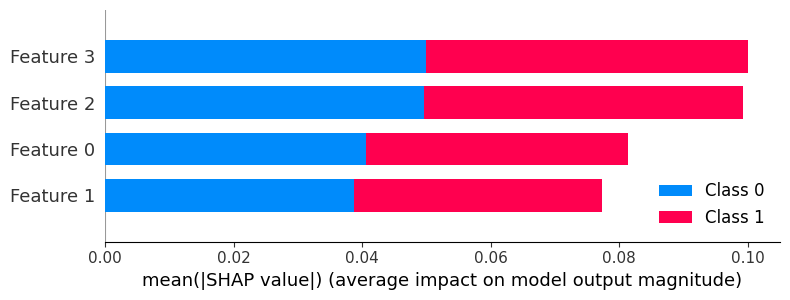

Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
Setuptools is replacing distutils.
[I 2023-09-22 12:48:43,251] A new study created in memory with name: no-name-ee4704a9-7c6f-49a0-b1ab-2eb0d8e68e8d
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2023-09-22 12:48:43,367] Trial 0 finished with value: 0.53 and parameters: {'n_estimators': 59, 'max_depth': 21, 'learning_rate': 0.008276430817884936}. Best is trial 0 with value: 0.53.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v

Best param of XGBoost = {'n_estimators': 37, 'max_depth': 24, 'learning_rate': 0.7365870506376211}
Model = XGBoost


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


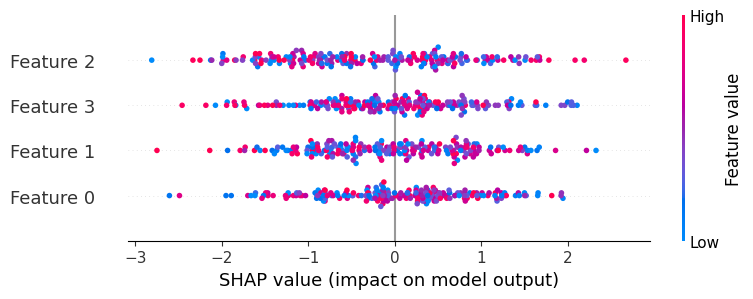

Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
Setuptools is replacing distutils.


In [25]:
if __name__ == "__main__":
    # Load your tabular data into a DataFrame
    # data = pd.read_csv('your_data.csv')

    # Initialize the TabularClassifier class
    classifier = TabularClassifier(data, target_column='target', categorical_columns = ['feature1','feature2','feature3','feature4'])

    train = classifier.model_training(model_type = "all", n_trials=50)


[13:00:37] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


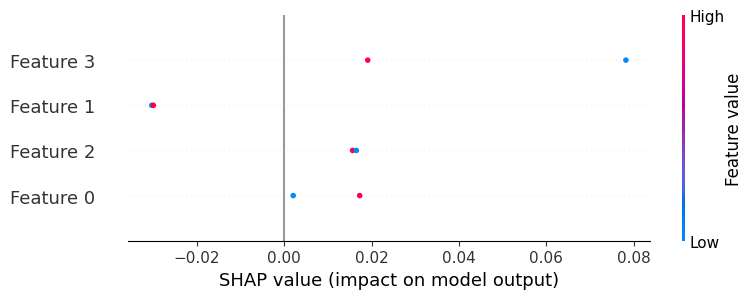

Prediction = [1 1]


In [33]:
model_path = "/home/ram/Documents/projects/AutoML/mlruns/942015216855672436/1aef336801d642e599a74e114f36e3aa/artifacts/XGBoost"

test_data = [[5.06158385e-03, 2.73626666e-01, 2.92218230e-01, 4.39210601e-01],
 [3.58465729e-01, 2.18253888e-01, 9.84989656e-01, 1.54828613e-01]]
# [8.17590319e-02, 3.24333753e-01, 7.40904056e-01, 7.97732263e-01]

pred = classifier.prediction(model_path, test_data)
print("Prediction =",pred)